In [ ]:
import numpy as np
import numpy.linalg as lng  # linear algebra
import matplotlib.pyplot as plt
import scipy.stats as stats  # pour la fonction de repartition de la loi normale
import pandas as pd  # pour un meilleur affichage des tables
import time
import scipy.linalg as slng

# **1. Explicit Euler Scheme**

In [ ]:
""" Paramètres constants: """
r=0.1
sigma=0.3
S_max=250
S_min=50
K=100
T=1
s_val = 90

def uleft(t):
  return K - S_min

def uright(t):
  return 0

def payoff(s):
  return max(K - s, 0)

def parametres(I):
    h = (S_max - S_min) / I
    s = np.linspace(S_min, S_max, I+1)
    alpha = ((sigma * s/h)**2) / 2
    beta = r * s / (2 * h)
    return h, s, alpha, beta

def create_U0(I):
  h,s,alpha,beta = parametres(I)
  U0 = np.zeros(I)
  for i in range(I):
    U0[i] = payoff(s[i])
  return U0

def create_A(I):
  h,s,alpha,beta = parametres(I)
  main_diag = 2*np.array(alpha[1:I+1]) + r
  lower_diag = -np.array(alpha[2:I+1]) + np.array(beta[2:I+1])
  upper_diag = -np.array(alpha[1:I]) - np.array(beta[1:I])
  A = np.diag(main_diag) + np.diag(lower_diag, -1) + np.diag(upper_diag, 1)
  return A

def q(t,I):
  h,s,alpha,beta = parametres(I)
  q = np.zeros(I)
  q[0] = (-alpha[1]+beta[1])*uleft(t)
  q[I-1] = (-alpha[I]-beta[I])*uright(t)
  return q


def ExplicitEuler(I,N):
  g = create_U0(I)
  U = g
  A = create_A(I)
  dt = T/N
  for n in range(N):
    tn = n*dt
    if I == N and I == 20:
      for i in range(I):
        U[i] = max(U[i]-dt*(A @ U + q(tn, I))[i], g[i])
    else:
      U = np.maximum(U - dt * (A @ U + q(tn, I)), g)
  return U


def plot_scheme(func, I, N):
  h,s,alpha,beta = parametres(I)
  U0_values = [payoff(s[i]) for i in range(I+1)]
  plt.plot(s[:I+1], U0_values, label='Payoff', linestyle='--',
           color = 'black')

  Scheme_values = func(I,N)
  plt.plot(s[:I], Scheme_values[:I],
             label=func.__name__, color = "b")

  plt.xlabel('Prix du sous-jacent (S)')
  plt.ylabel('Prix du Put')
  plt.title("Pricing du Put Américain par le schema {} avec T ={}, I= {},  N= {}".format(func.__name__,T,I,N))
  plt.legend()
  plt.yticks(range(0, int(max(U0_values)) + 10, 10))
  plt.grid(True)
  plt.show()
  print()



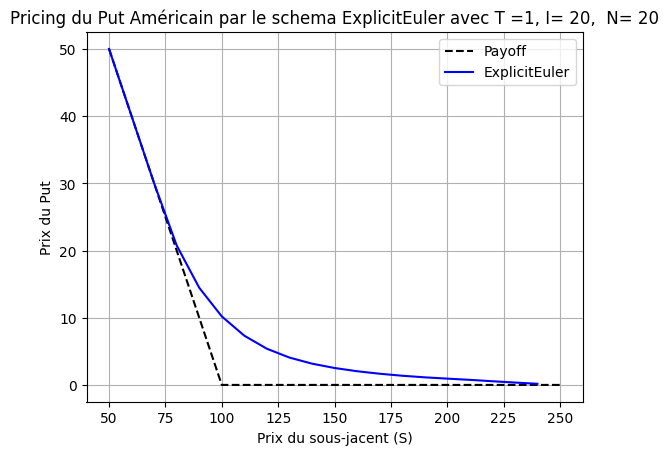

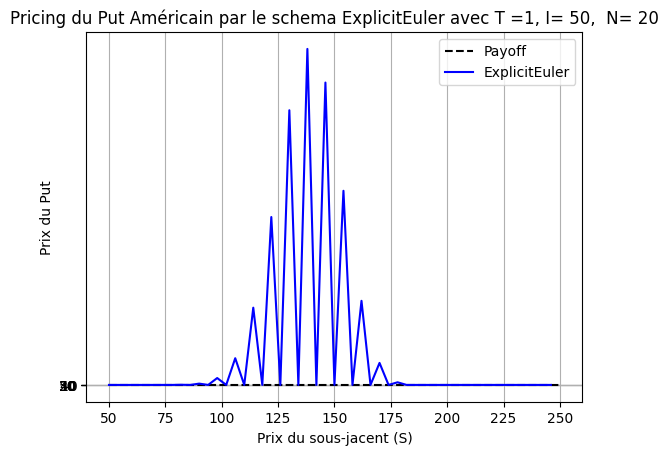

In [ ]:
plot_scheme(ExplicitEuler,20,20) #stable
plot_scheme(ExplicitEuler,50,20) #pas stable

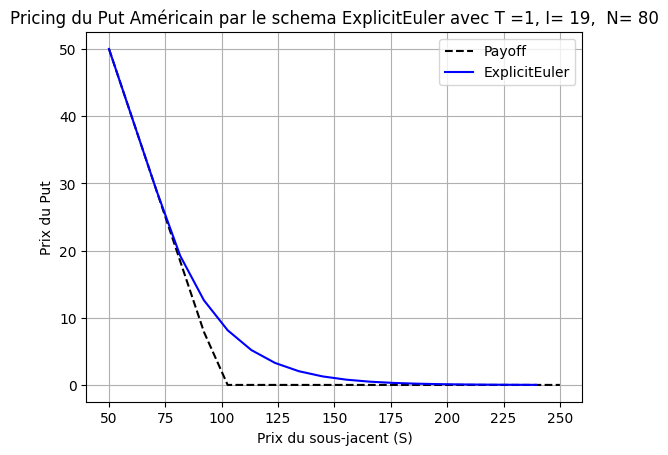

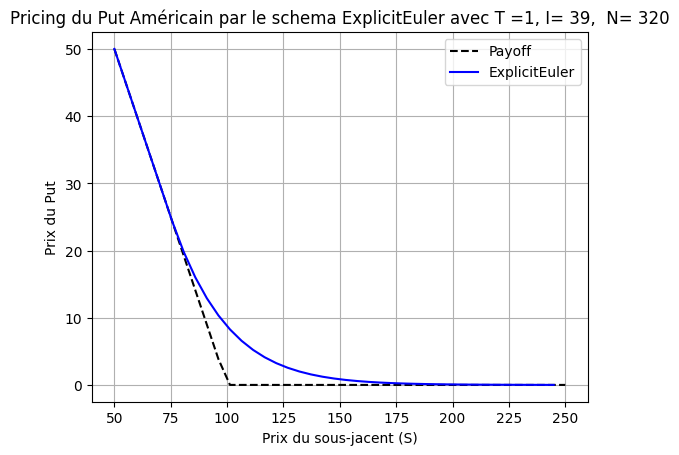

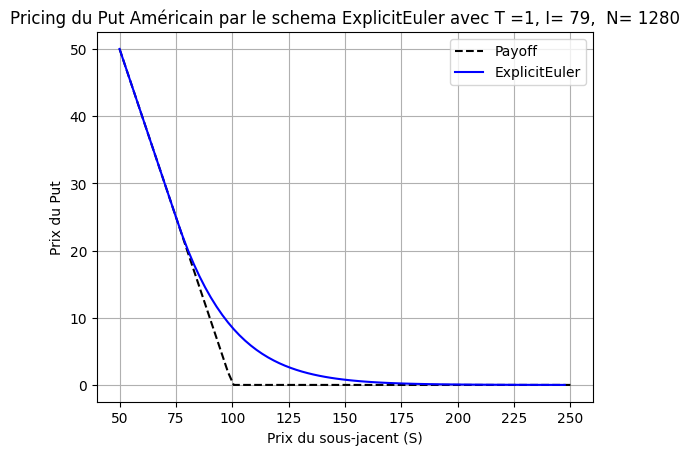

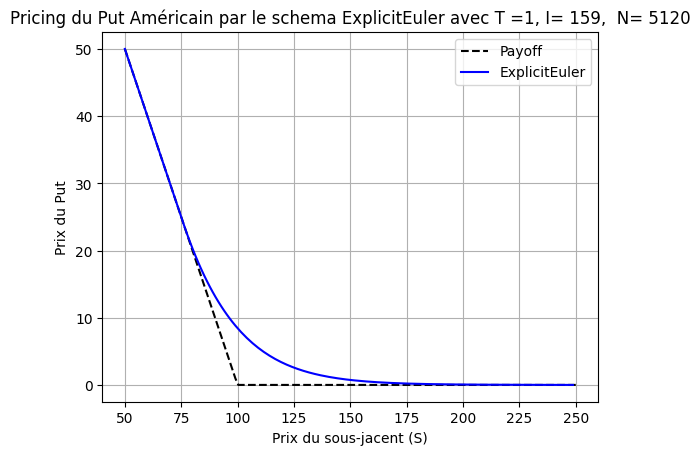

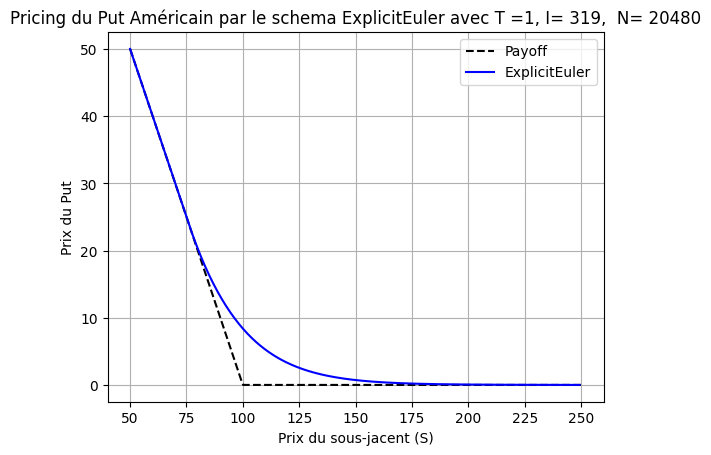

In [ ]:
I = [20,40,80,160,320]
for i in I:
  plot_scheme(ExplicitEuler,i-1 ,int(2*0.1*i**2))

In [ ]:
def P_Interpolate(s_bar,func,I,N):
  h,s,alpha,beta = parametres(I)
  s_ = np.array(s)
  i = np.searchsorted(s_, s_bar)
  U = func(I,N)
  u_bar=((s[i]-s_bar)*U[i-1]+(s_bar-s[i-1])*U[i])/h
  return float(u_bar)



def table(func,s_bar):
  I = [19,39,79,159,319]
  N = [int(2*0.1*(i+1)**2) for i in I]
  v,err,ord,tcpu = [],[],[],[]

  for i in range(len(I)):
    t0=time.time()
    P = P_Interpolate(s_bar, func, I[i], N[i])
    v.append(P)
    t1=time.time()
    tcpu_str = "tcpu=%5.6f"%(t1-t0)
    equal_sign_index = tcpu_str.index('=')
    numeric_part = tcpu_str[equal_sign_index + 1:]
    tcpu_float = float(numeric_part)
    tcpu.append(tcpu_float)

    if i == 0:
        err.append(0)
        ord.append(0)
    elif i == 1:
        err.append(np.abs(P - P_Interpolate(s_bar,func,I[i-1],N[i-1]) ))
        ord.append(0)
    else:
      err.append(np.abs( P - P_Interpolate(s_bar,func,I[i-1],N[i-1]) ))
      ord.append(np.log(err[i-1]/err[i]) / np.log(2))

  data = {"I":I, "N": N, "v":v, "err":err, "ord":ord, "tcpu": tcpu}
  result = pd.DataFrame(data)
  return result

table(ExplicitEuler,s_val)


,I,N,v,err,ord,tcpu
0,19,80,13.921274,0.000000,0.000000,0.008510
1,39,320,13.520378,0.400896,0.000000,0.015849
2,79,1280,13.308165,0.212213,0.917712,0.070894
3,159,5120,13.213613,0.094551,1.166345,0.570235
4,319,20480,13.166678,0.046936,1.010412,2.781740


# **2. A first implicit scheme: the splitting scheme**

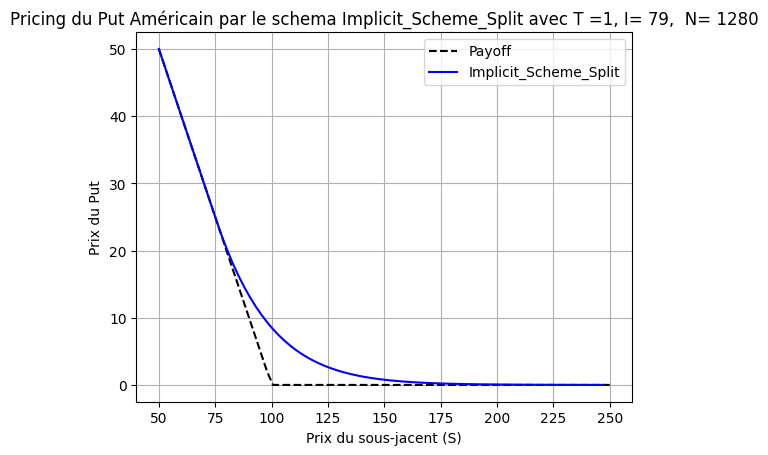

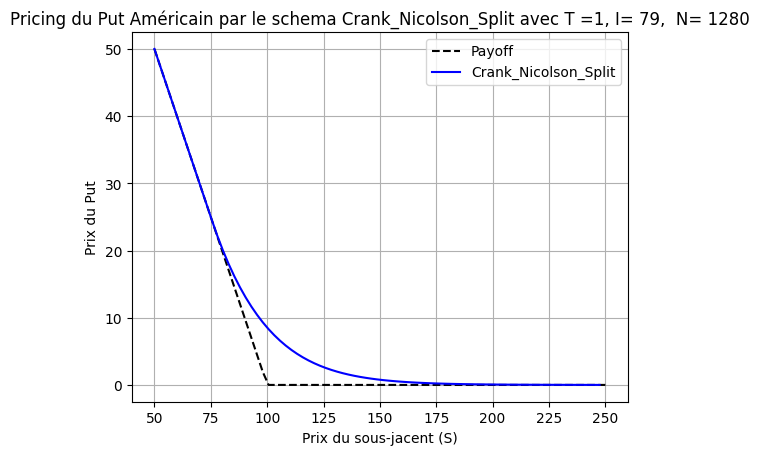

In [ ]:
def Implicit_Scheme_Split(I,N):
  U = create_U0(I)
  A = create_A(I)
  g,U_ = U,U
  dt = T/N
  for n in range(N):
    tn = (n+1)*dt
    U_ = lng.solve(np.identity(I)+dt*A,U -dt*q(tn,I))
    U = np.maximum(U_, g)
  return U


#cas theta = 1/2
def Crank_Nicolson_Split(I,N):
  U = create_U0(I)
  A = create_A(I)
  g,U_ = U,U
  dt = T/N
  for n in range(N):
    tn_ = (n+1)*dt
    tn = n*dt
    U_ = lng.solve(np.identity(I)+0.5*dt*A, U-0.5*dt*(q(tn,I)+ q(tn_,I)+ A@U))
    U = np.maximum(U_, g)
  return U



plot_scheme(Implicit_Scheme_Split,79,1280)
plot_scheme(Crank_Nicolson_Split,79,1280)


In [ ]:
def table_split(func,s_bar):
  N = [20*(2**k) for k in range(5)]
  I = [(i-1) for i in N]
  v,err,ord,tcpu = [],[],[],[]

  for i in range(len(I)):
    t0=time.time()
    P = P_Interpolate(s_bar, func, I[i], N[i])
    v.append(P)
    t1=time.time()
    tcpu_str = "tcpu=%5.6f"%(t1-t0)
    equal_sign_index = tcpu_str.index('=')
    numeric_part = tcpu_str[equal_sign_index + 1:]
    tcpu_float = float(numeric_part)
    tcpu.append(tcpu_float)

    if i == 0:
        err.append(0)
        ord.append(0)
    elif i == 1:
        err.append(np.abs(P - P_Interpolate(s_bar,func,I[i-1],N[i-1]) ))
        ord.append(0)
    else:
      err.append(np.abs( P - P_Interpolate(s_bar,func,I[i-1],N[i-1]) ))
      ord.append(np.log(err[i-1]/err[i]) / np.log(2))

  data = {"I":I, "N": N, "v":v, "err":err, "ord":ord, "tcpu": tcpu}
  result = pd.DataFrame(data)
  return result

In [ ]:
print("Table de convergence du schéma implicite")
table_split(Implicit_Scheme_Split,s_val)

Table de convergence du schéma implicite


,I,N,v,err,ord,tcpu
0,19,20,13.680616,0.000000,0.000000,0.007233
1,39,40,13.397628,0.282988,0.000000,0.013180
2,79,80,13.253115,0.144513,0.969546,0.026242
3,159,160,13.184719,0.068396,1.079214,0.124279
4,319,320,13.152218,0.032501,1.073424,1.021351


In [ ]:
print("Table de convergence du schéma de décomposition de Crank-Nicolson")
table_split(Crank_Nicolson_Split,s_val)

Table de convergence du schéma de décomposition de Crank-Nicolson


,I,N,v,err,ord,tcpu
0,19,20,8.114038,0.000000,0.000000,0.005706
1,39,40,10.391869,2.277832,0.000000,0.012456
2,79,80,11.703390,1.311520,0.796421,0.040118
3,159,160,12.396817,0.693428,0.919422,0.147880
4,319,320,12.755129,0.358312,0.952530,1.284084


# **3. Implicit Euler Scheme**

*PSOR Algorithm (PSOR = ”Projected Successive Over Relaxation”):*

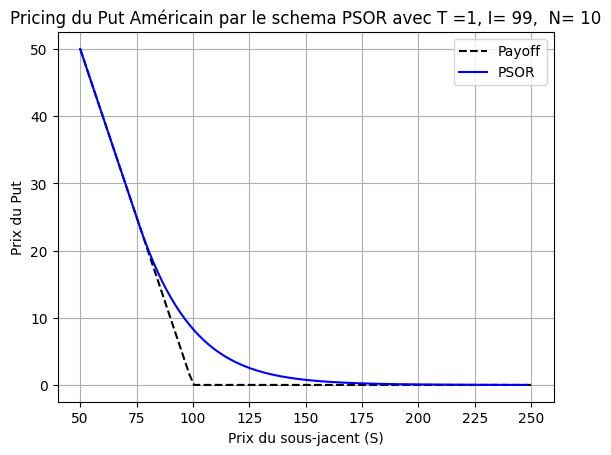

In [ ]:
def PSOR(I, N, x0, kmax=1000, eta=1e-6):
    A = create_A(I)
    dt = T / N
    B = np.eye(I) + dt * A
    U_n = create_U0(I)
    g = U_n.copy()

    # Boucle sur les pas de temps
    for n in range(N):
        b = U_n - dt * q((n)*dt, I)
        x = x0.copy()
        xold = x.copy()
        for k in range(kmax):
            xold[:] = x
            for i in range(I):
                sum1 = np.dot(B[i, :i], x[:i])
                sum2 = np.dot(B[i, i+1:], xold[i+1:])
                x[i] = (b[i] - sum1 - sum2) / B[i, i]
                x[i] = max(x[i], g[i])
            if np.linalg.norm(x - xold, np.inf) < eta:
                break
        U_n = x
    return U_n


def plot_scheme2(func,I, N):
  h,s,alpha,beta = parametres(I)
  x0 = create_U0(I) #initial guess
  U0_values = [payoff(s[i]) for i in range(I+1)]
  plt.plot(s[:I+1], U0_values, label='Payoff', linestyle='--',
           color = 'black')

  Scheme_values = func(I, N,x0)
  plt.plot(s[:I], Scheme_values[:I],
             label=func.__name__, color = "b")

  plt.xlabel('Prix du sous-jacent (S)')
  plt.ylabel('Prix du Put')
  plt.title("Pricing du Put Américain par le schema {} avec T ={}, I= {},  N= {}".format(func.__name__,T,I,N))
  plt.legend()
  plt.yticks(range(0, int(max(U0_values)) + 10, 10))
  plt.grid(True)
  plt.show()
  print()

plot_scheme2(PSOR,99,10)


3.2 *Semi-smooth Newton’s method*

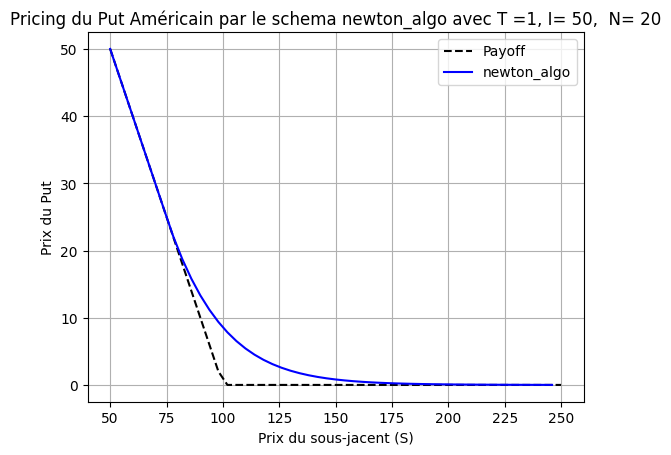

In [ ]:
def F(B,b,x,g):
  return np.minimum(np.dot(B,x) - b,x-g)


def F_(B, b, x, g): # F'
    condition = np.dot(B, x) - b <= x - g
    return np.where(condition[:, None], B, np.eye(len(B)))


def newton(B,b,x,g,x0,kmax=100,eta=1e-6):
  x = x0.copy()
  for i in range(kmax):
    xold = x.copy()
    x -= lng.inv(F_(B,b,x,g)) @ F(B,b,x,g)
    if lng.norm(x-xold) < eta:
      return x
  return x

def newton_algo(I,N,x0):
    A = create_A(I)
    dt = T / N
    B = np.eye(I) + dt * A
    g = create_U0(I)
    x = x0.copy()

    for n in range(N):
      b = x - dt*q((n+1)*dt, I)
      x = newton(B,b,x,g,x0)
    return x


plot_scheme2(newton_algo,50,20)

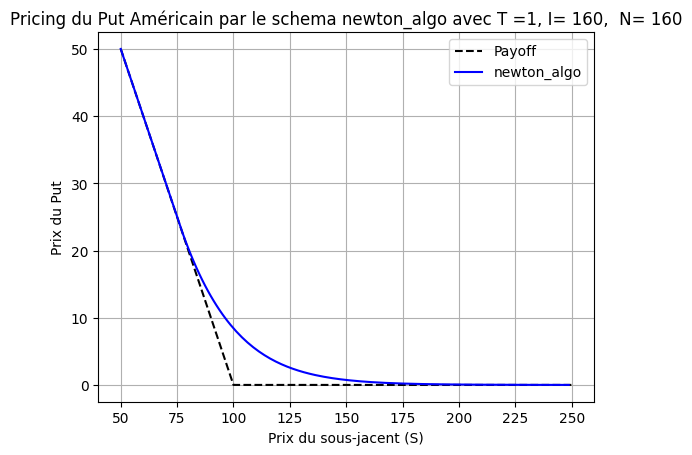

In [ ]:
plot_scheme2(newton_algo,160,160)

In [ ]:
def P_Interpolate_newton(s_bar,func,I,N):
  h,s,alpha,beta = parametres(I)
  s_ = np.array(s)
  i = np.searchsorted(s_, s_bar)
  x0 = create_U0(I)
  U = func(I,N,x0)
  u_bar=((s[i]-s_bar)*U[i-1]+(s_bar-s[i-1])*U[i])/h
  return float(u_bar)

def table_newton2(func,s_bar, case):
  I = [20*(2**k) for k in range(5)]
  if case == 0: #cas où I == N
    N = I
  if case == 1:
    N = [int(j*0.1) for j in I]
  v,err,ord,tcpu = [],[],[],[]

  for i in range(len(I)):

    t0=time.time()
    P = P_Interpolate_newton(s_bar, func, I[i], N[i])
    v.append(P)
    t1=time.time()
    tcpu_str = "tcpu=%5.6f"%(t1-t0)
    equal_sign_index = tcpu_str.index('=')
    numeric_part = tcpu_str[equal_sign_index + 1:]
    tcpu_float = float(numeric_part)
    tcpu.append(tcpu_float)

    if i == 0:
        err.append(0)
        ord.append(0)
    elif i == 1:
        err.append(np.abs(P - P_Interpolate_newton(s_bar,func,I[i-1],N[i-1]) ))
        ord.append(0)
    else:
      err.append(np.abs( P - P_Interpolate_newton(s_bar,func,I[i-1],N[i-1]) ))
      ord.append(np.log(err[i-1]/err[i]) / np.log(2))

  data = {"I":I, "N": N, "v":v, "err":err, "ord":ord, "tcpu": tcpu}
  result = pd.DataFrame(data)
  return result

In [ ]:
table_newton2(newton_algo, s_val,0) #cas I = N

,I,N,v,err,ord,tcpu
0,20,20,13.548691,0.000000,0.000000,0.024637
1,40,40,13.406152,0.142539,0.000000,0.018627
2,80,80,13.271841,0.134311,0.085778,0.088246
3,160,160,13.199803,0.072038,0.898747,0.905284
4,320,320,13.160831,0.038972,0.886325,12.771817


In [ ]:
table_newton2(newton_algo, s_val,1) #cas I = 10*N

,I,N,v,err,ord,tcpu
0,20,2,13.037600,0.000000,0.000000,0.003172
1,40,4,13.119487,0.081887,0.000000,0.017406
2,80,8,13.126655,0.007167,3.514133,0.018578
3,160,16,13.124351,0.002304,1.637241,0.171083
4,320,32,13.122016,0.002335,-0.019237,2.378278


*3.3 Brennan and Schwartz algorithm*

In [ ]:

def uldecomp(B):
  P, L, U = slng.lu(B) # scipy.linalg as slng
  return U,L   # B = LU, L triangulaire inf et U triangulaire inf


def check_decomp(B):
  U,L = uldecomp(B)
  print('norme de B-UL: ',lng.norm(B-L@U,np.inf));


def upwind(U, b):
    c = lng.solve(U,b)
    return c

def descente_p(L, c, g):
    x = np.zeros_like(c)
    for i in range(len(c)):
        x[i] = max((c[i] - L[i, :i] @ x[:i]) / L[i, i], g[i])
    return x

def projected_UL_algorithm(I, N, x0):
    g = create_U0(I)
    A = create_A(I)
    dt = T/N
    B = np.identity(I) + dt*A
    U, L = uldecomp(B)

    x = x0.copy()

    for n in range(N):
      xold = x.copy()
      b = x - dt * q((n+1)*dt, I)
      c = upwind(U, b)
      x = descente_p(L, c, g)
      if N - n <= 10: # on affiche juste les 10 dernieres normes
        err = np.linalg.norm(np.minimum(B @ x - xold, x - g), np.inf)
        print(f'Check: |min(B x- b, x-g)|_inf= {err}')

    return x


In [ ]:
#Test de la décomposition

A = create_A(9)
dt = T/10
B = np.identity(9) + dt*A
check_decomp(B)

norme de B-UL:  5.551115123125783e-17


Check: |min(B x- b, x-g)|_inf= 0.011347697480747598
Check: |min(B x- b, x-g)|_inf= 0.011257230557214726
Check: |min(B x- b, x-g)|_inf= 0.011169610739028002
Check: |min(B x- b, x-g)|_inf= 0.011084581678918681
Check: |min(B x- b, x-g)|_inf= 0.01100192350410012
Check: |min(B x- b, x-g)|_inf= 0.010921446843481064
Check: |min(B x- b, x-g)|_inf= 0.010842987906109158
Check: |min(B x- b, x-g)|_inf= 0.010766404415111452
Check: |min(B x- b, x-g)|_inf= 0.01069157223968098
Check: |min(B x- b, x-g)|_inf= 0.010618382598137188


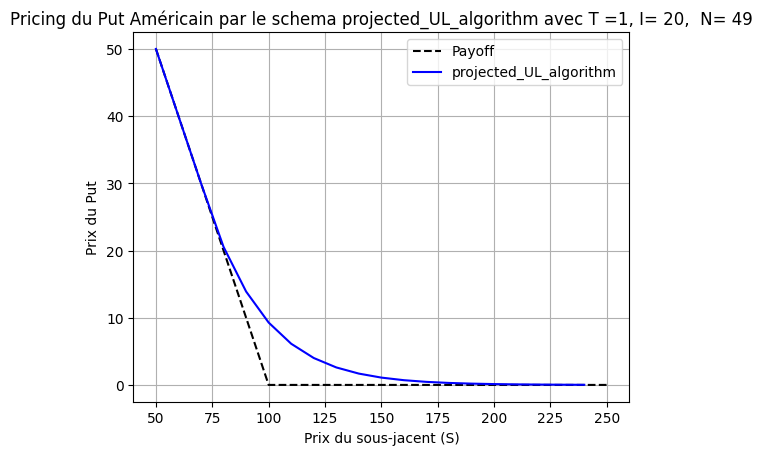

In [ ]:
plot_scheme2(projected_UL_algorithm,20,49)

Check: |min(B x- b, x-g)|_inf= 0.022921229461907444
Check: |min(B x- b, x-g)|_inf= 0.02285622925343489
Check: |min(B x- b, x-g)|_inf= 0.022791453147931406
Check: |min(B x- b, x-g)|_inf= 0.022726907993021683
Check: |min(B x- b, x-g)|_inf= 0.022662605723695606
Check: |min(B x- b, x-g)|_inf= 0.022598560553575453
Check: |min(B x- b, x-g)|_inf= 0.022534787368698517
Check: |min(B x- b, x-g)|_inf= 0.022471300820399165
Check: |min(B x- b, x-g)|_inf= 0.022408114828163406
Check: |min(B x- b, x-g)|_inf= 0.022346413549154676


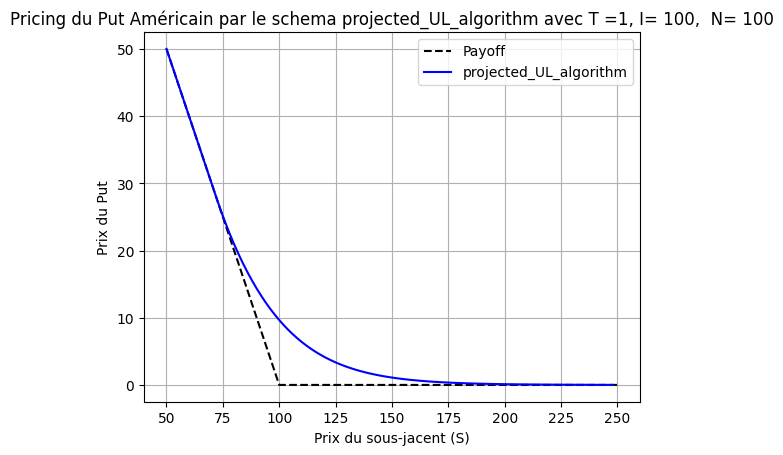

In [ ]:
plot_scheme2(projected_UL_algorithm,100,100)

Check: |min(B x- b, x-g)|_inf= 0.0004741063202864382
Check: |min(B x- b, x-g)|_inf= 0.0004739283906918246
Check: |min(B x- b, x-g)|_inf= 0.00047375067854993347
Check: |min(B x- b, x-g)|_inf= 0.0004735731866869486
Check: |min(B x- b, x-g)|_inf= 0.0004733959179237246
Check: |min(B x- b, x-g)|_inf= 0.0004732188750544708
Check: |min(B x- b, x-g)|_inf= 0.0004730420608520802
Check: |min(B x- b, x-g)|_inf= 0.0004728654780361552
Check: |min(B x- b, x-g)|_inf= 0.00047268912928011275
Check: |min(B x- b, x-g)|_inf= 0.0004725130171774339


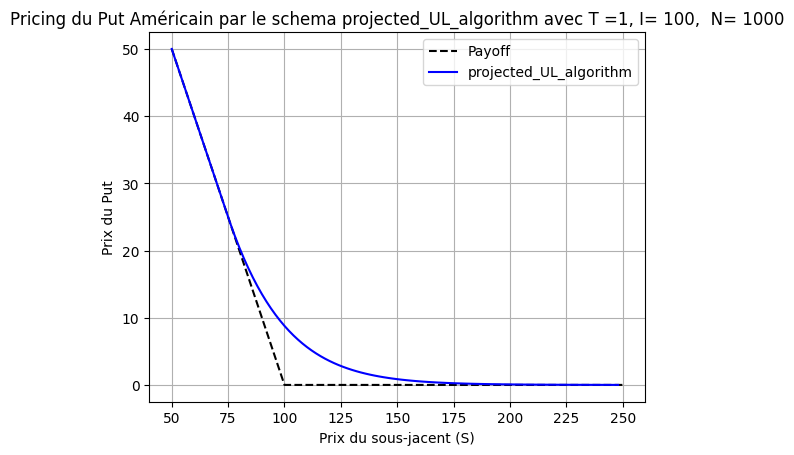

In [ ]:
plot_scheme2(projected_UL_algorithm,100,1000)

## On remarque bien que quand N augmente, la norme décroit

Check: |min(B x- b, x-g)|_inf= 0.08188002773405856
Check: |min(B x- b, x-g)|_inf= 0.08073325237192819
Check: |min(B x- b, x-g)|_inf= 0.07962968914620205
Check: |min(B x- b, x-g)|_inf= 0.07856681976085156
Check: |min(B x- b, x-g)|_inf= 0.07754232441065767
Check: |min(B x- b, x-g)|_inf= 0.07655406225219963
Check: |min(B x- b, x-g)|_inf= 0.07571965811185066
Check: |min(B x- b, x-g)|_inf= 0.07490993858962014
Check: |min(B x- b, x-g)|_inf= 0.07412200538698954
Check: |min(B x- b, x-g)|_inf= 0.07362438098674567


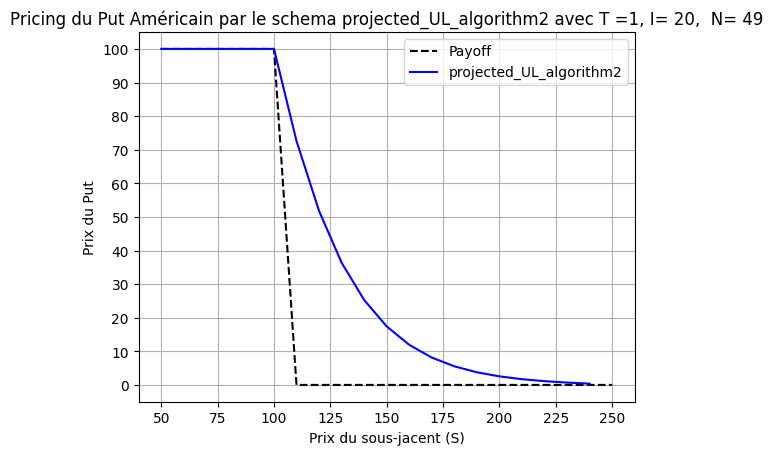

In [ ]:
#Test avec phi2 et avec les changements nécessaires

def phi2(s):
  if K/2 <= s and s <= K:
    return K
  return 0


def create_U02(I):
  h,s,alpha,beta = parametres(I)
  U0 = np.zeros(I)
  for i in range(I):
    U0[i] = phi2(s[i])
  return U0

def uleft2(t):
  return 0

def q2(t,I):
  h,s,alpha,beta = parametres(I)
  q = np.zeros(I)
  q[0] = (-alpha[1]+beta[1])*uleft2(t)
  q[I-1] = (-alpha[I]-beta[I])*uright(t)
  return q


def projected_UL_algorithm2(I, N, x0):
    g = create_U02(I)
    A = create_A(I)
    dt = T/N
    B = np.identity(I) + dt*A
    U, L = uldecomp(B)

    x = x0.copy()

    for n in range(N):
      xold = x.copy()
      b = x - dt * q2((n+1)*dt, I)
      c = upwind(U, b)
      x = descente_p(L, c, g)
      if N - n <= 10: # on affiche juste les 10 dernieres normes
        err = np.linalg.norm(np.minimum(B @ x - xold, x - g), np.inf)
        print(f'Check: |min(B x- b, x-g)|_inf= {err}')

    return x

def plot_scheme3(func,I, N):
  h,s,alpha,beta = parametres(I)
  x0 = create_U02(I) #initial guess
  U0_values = [phi2(s[i]) for i in range(I+1)]
  plt.plot(s[:I+1], U0_values, label='Payoff', linestyle='--',
           color = 'black')

  Scheme_values = func(I, N,x0)
  plt.plot(s[:I], Scheme_values[:I],
             label=func.__name__, color = "b")

  plt.xlabel('Prix du sous-jacent (S)')
  plt.ylabel('Prix du Put')
  plt.title("Pricing du Put Américain par le schema {} avec T ={}, I= {},  N= {}".format(func.__name__,T,I,N))
  plt.legend()
  plt.yticks(range(0, int(max(U0_values)) + 10, 10))
  plt.grid(True)
  plt.show()
  print()

plot_scheme3(projected_UL_algorithm2,20,49)

Check: |min(B x- b, x-g)|_inf= 0.010445244564194288
Check: |min(B x- b, x-g)|_inf= 0.010487267475018179
Check: |min(B x- b, x-g)|_inf= 0.010529368536754104
Check: |min(B x- b, x-g)|_inf= 0.010571547612181861
Check: |min(B x- b, x-g)|_inf= 0.01061380456372673
Check: |min(B x- b, x-g)|_inf= 0.01065613925346285
Check: |min(B x- b, x-g)|_inf= 0.010698551543116476
Check: |min(B x- b, x-g)|_inf= 0.01074104129406954
Check: |min(B x- b, x-g)|_inf= 0.010783608367362793
Check: |min(B x- b, x-g)|_inf= 0.010826252623699358


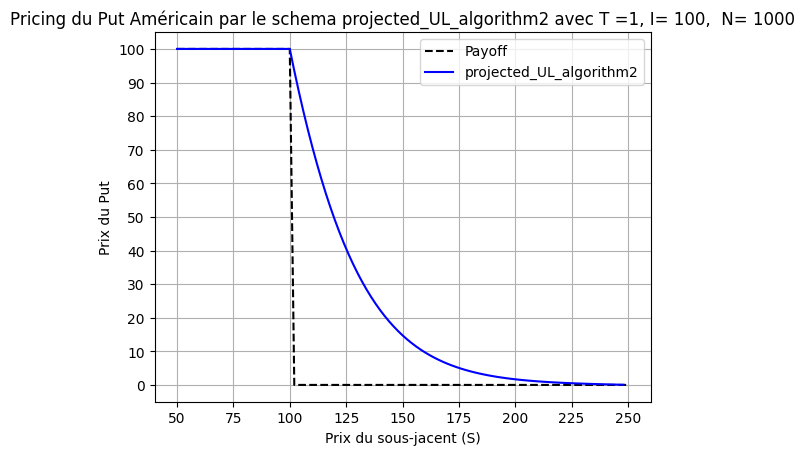

In [ ]:
plot_scheme3(projected_UL_algorithm2,100,1000)

In [ ]:
#On vérifie que min(Bx − b, x − g) != 0 dès que n = 0
#toujours pour le cas de phi2

def check(I,N,x0):
    g = create_U02(I)
    A = create_A(I)
    dt = T/N
    B = np.identity(I) + dt*A
    n = 0
    x = x0.copy()
    b = x0 - dt*q2((n+1)*dt,I)
    result = np.minimum(B@x-b,x-g) != np.zeros
    print(f"min(Bx−b,x−g) != 0 for n = {n}: ", np.all(result))

check(20,20,create_U02(20))

min(Bx−b,x−g) != 0 for n = 0:  True


# **4. A higher order scheme**

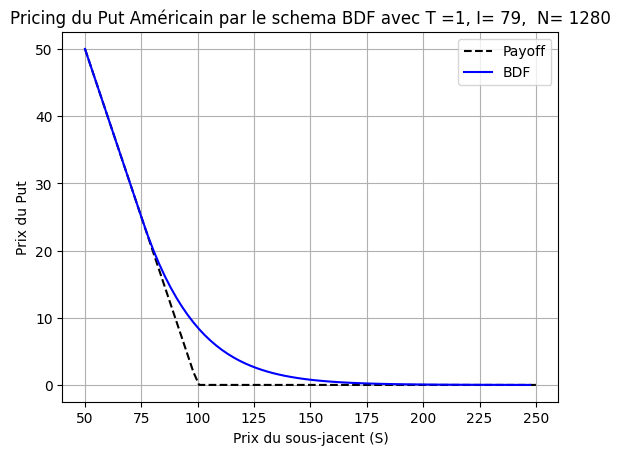

In [ ]:
"""
Les schémas IE et CN ont déjà étaient fait en section 2, ainsi que leur tables
respectives. On traite ici le cas du BDF.
"""

def BDF(I,N):
  U = create_U0(I)
  A = create_A(I)
  g,U_ = U,U
  dt = T/N
  vec = [0]*N
  vec[0] = U_
  U_ = lng.solve(np.identity(I)+dt*A,U -dt*q(2*dt,I))
  vec[1] = np.maximum(U_, g) #on calcul U1 avec EI
  for n in range(2,N):
    q_ = q((n+1)*dt,I)
    U_ = lng.solve(3*np.identity(I)+2*dt*A,
                   4*vec[n-1]-vec[n-2]-2*dt*q_)
    vec[n] = np.maximum(U_,g)
  return vec[N-1]

plot_scheme(BDF,79,1280)

In [ ]:
def table2(func,s_bar,case):
  I = [20*(2**k) for k in range(5)]
  if case == 0: #cas où I == N
    N = I
  if case == 1: #cas I = 10*N
    N = [int(j*0.1) for j in I]
  v,err,ord,tcpu = [],[],[],[]

  for i in range(len(I)):
    t0=time.time()
    P = P_Interpolate(s_bar, func, I[i], N[i])
    v.append(P)
    t1=time.time()
    tcpu_str = "tcpu=%5.6f"%(t1-t0)
    equal_sign_index = tcpu_str.index('=')
    numeric_part = tcpu_str[equal_sign_index + 1:]
    tcpu_float = float(numeric_part)
    tcpu.append(tcpu_float)

    if i == 0:
        err.append(0)
        ord.append(0)
    elif i == 1:
        err.append(np.abs(P - P_Interpolate(s_bar,func,I[i-1],N[i-1]) ))
        ord.append(0)
    else:
      err.append(np.abs( P - P_Interpolate(s_bar,func,I[i-1],N[i-1]) ))
      ord.append(np.log(err[i-1]/err[i]) / np.log(2))

  data = {"I":I, "N": N, "v":v, "err":err, "ord":ord, "tcpu": tcpu}
  result = pd.DataFrame(data)
  return result

In [ ]:
print("Table de convergence du schéma BDF pour I == N")
table2(BDF,s_val, 0)

Table de convergence du schéma BDF pour I == N


,I,N,v,err,ord,tcpu
0,20,20,13.464816,0.000000,0.000000,0.008165
1,40,40,13.345411,0.119405,0.000000,0.012050
2,80,80,13.246905,0.098506,0.277581,0.024432
3,160,160,13.185388,0.061517,0.679238,0.127271
4,320,320,13.153573,0.031815,0.951266,1.075796
5,640,640,13.137190,0.016383,0.957500,12.641779


In [ ]:
print("Table de convergence du schéma BDF pour I = 10*N")
table2(BDF,s_val, 1)

Table de convergence du schéma BDF pour I = 10*N


,I,N,v,err,ord,tcpu
0,20,2,10.000000,0.000000,0.000000,0.000748
1,40,4,13.944488,3.944488,0.000000,0.010744
2,80,8,13.113301,0.831186,2.246594,0.004677
3,160,16,13.043939,0.069362,3.582948,0.011930
4,320,32,13.067135,0.023196,1.580293,0.116990
